[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 60, 50)            8400      
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_4 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 50)                15300     
                                             

10/10 [==============================] - 1s 86ms/step - loss: 0.0040 - val_loss: 9.6511e-04
Epoch 66/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 67/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0037 - val_loss: 7.2350e-04
Epoch 68/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 69/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 70/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0035 - val_loss: 6.6315e-04
Epoch 71/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 72/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 73/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 74/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0037 - val_loss

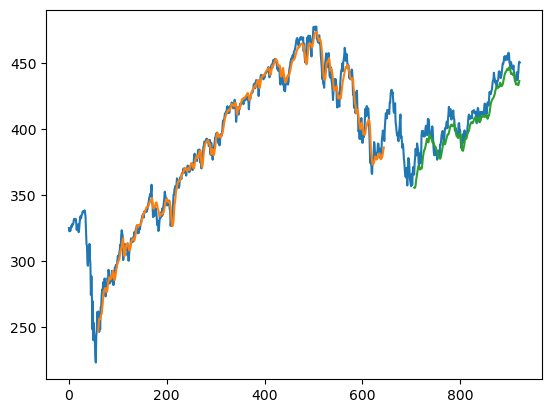

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

## Get input data
# Download stock data
symbol = "SPY"
data = yf.download(symbol, start="2020-01-01", end="2023-09-01")

# VIX index input
vix = yf.download('^VIX', start="2020-01-01", end="2023-09-01")
data['VIX'] = vix['Close']

# risk free rate, input
rf = yf.download('^TNX', start="2020-01-01", end="2023-09-01")
data['Risk_Free_Rate'] = rf['Close'] / 100 # percentage

# drop the NaN
data = data.dropna()

# data sample
df = data.loc[:,['Close','Volume','VIX','Risk_Free_Rate']]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Split train and test set
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# calling the create dataset function to split the data into 
# input output datasets with time step 60
time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))  
model.add(GRU(50))
model.add(Dropout(0.2))  
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# check the running time
start_time = time.time()

# Model training
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
          epochs=100, batch_size=64, verbose=1)

# end to check the time
end_time = time.time()

# print the running time
print("Learning time: ", end_time - start_time, "seconds")

# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(np.c_[train_predict, np.zeros((train_predict.shape[0], 3))])[:, 0]
test_predict = scaler.inverse_transform(np.c_[test_predict, np.zeros((test_predict.shape[0], 3))])[:, 0]

# We need to reshape Y_train and Y_test to add the features dimensions back that we dropped before 
# since the scaler expects the same number of features to inverse_transform
# As the scaler was fit on data with 4 features, we need to transform it back accordingly.

# First, reshape Y_train and Y_test to the original shape
Y_train = Y_train.reshape(-1, 1)
Y_train = np.c_[Y_train, np.zeros((Y_train.shape[0], df.shape[1]-1))]  # df.shape[1]-1 because we don't have 'Open', 'High', 'Low'
Y_test = Y_test.reshape(-1, 1)
Y_test = np.c_[Y_test, np.zeros((Y_test.shape[0], df.shape[1]-1))]  # df.shape[1]-1 for the same reason

# Now, use inverse_transform to scale back to original representation
Y_train = scaler.inverse_transform(Y_train)[:, 0]
Y_test = scaler.inverse_transform(Y_test)[:, 0]

# Now calculate RMSE in the original scale
print("Train RMSE: ", np.sqrt(mean_squared_error(Y_train, train_predict)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Y_test, test_predict)))

# Plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict) + time_step, 0] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, 0] = test_predict

plt.plot(scaler.inverse_transform(scaled_data)[:, 0])
plt.plot(trainPredictPlot[:, 0])
plt.plot(testPredictPlot[:, 0])
plt.show()